In [1]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, spearmanr
import mplcursors
import EpiClockNBL.src.util as pc_util
pc_consts = pc_util.consts

In [2]:
proj_dir = os.path.join(pc_consts['official_indir'], 'TARGET')
gmm_peak_indir = os.path.join(pc_consts['repo_dir'], 'Gaussian Mixture Model')

In [3]:
figure_outdir = 'figures'
os.makedirs(figure_outdir, exist_ok=True)

## Prepare data

In [4]:
os.path.join(proj_dir, 'NBL.methyl.antiNonIterClustNotStuck_sites.tsv')

'/Users/grahamgumbert/Library/CloudStorage/Box-Box/PROJECT 06023: MolClocks/Neuroblastoma_Paper/Datasets/TARGET/NBL.methyl.antiNonIterClustNotStuck_sites.tsv'

In [5]:
clinical = {}
clinical['TARGET'] = pd.read_table(os.path.join(proj_dir, 'clinical.annotated.tsv'), index_col=0)

# Import Clock beta values for TCGA
beta_values_Clock = pd.read_table(os.path.join(proj_dir, 'NBL.methyl.antiNonIterClustNotStuck_sites.tsv'),
                      index_col=0).rename(columns=pc_util.sampleToPatientID)

clinical['TARGET']['c_beta'] = 1 - beta_values_Clock.std()

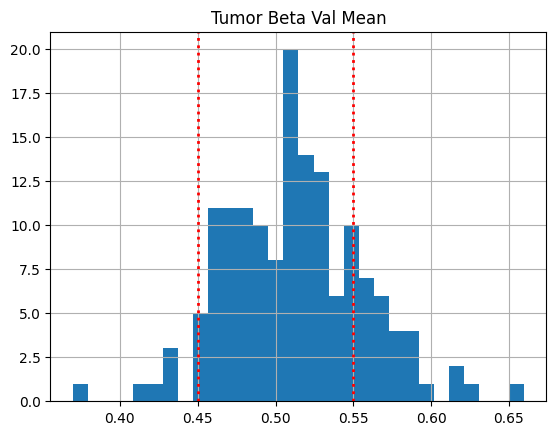

In [10]:
mean_beta_values = beta_values_Clock.mean(axis=0)

fig, ax = plt.subplots()
mean_beta_values.hist(bins=30, ax=ax)
ax.set_title("Tumor Beta Val Mean")

ax.axvline(x=0.45, color='red', linestyle='dotted', linewidth=2)
ax.axvline(x=0.55, color='red', linestyle='dotted', linewidth=2)

plt.show()

bad_mean_tumors = beta_values_Clock.mean(axis=0)[(beta_values_Clock.mean(axis=0) < 0.45) | (beta_values_Clock.mean(axis=0) > 0.55)]

good_mean_tumors = beta_values_Clock.columns.difference(bad_mean_tumors.index)

with open(os.path.join(pc_consts['repo_dir'], "data", "good_mean_tumors.txt"), "w") as f:
    for tumor in good_mean_tumors:
        f.write(f"{tumor}\n")

### Gaussian Mixture Model data

In [135]:
gmm_params = {}

for dataset in ['TARGET']:
    print()
    print(dataset)
    
    # Import GMM decomposition raw outputs
    # i.e. GMM's parameters and weights
    gmm_params[dataset] = pd.read_csv(os.path.join(gmm_peak_indir, dataset, 'tumor_params_GMM_summary.csv'))

    gmm_params[dataset].rename(columns={"Tumor": "submitter_id"}, inplace=True)
    
    gmm_params[dataset]["submitter_id"] = (
        gmm_params[dataset]["submitter_id"]
        .str.replace(r"\.01[ABC]$", "", regex=True)
        .str.replace(r"\.", "-", regex=True)
    )
    
    gmm_params[dataset].set_index("submitter_id", inplace=True)
    
    clinical[dataset]['gmm_X'] = gmm_params[dataset]["X_mean"]
    
    clinical[dataset]['gmm_phi'] = gmm_params[dataset]["phi_mean"]

    clinical[dataset]['psi_1_mean'] = gmm_params[dataset]["psi_1_mean"]

    clinical[dataset]['psi_2_mean'] = gmm_params[dataset]["psi_2_mean"]

    clinical[dataset]['psi_3_mean'] = gmm_params[dataset]["psi_3_mean"]
    
    clinical[dataset] = clinical[dataset].loc[~clinical[dataset]['gmm_phi'].isna()]

    clinical[dataset].name = "TARGET"

    display(clinical[dataset])

    clinical[dataset].to_csv(os.path.join(proj_dir, 'clinical.annotated.tsv'), sep='\t')


TARGET


,project,disease_type,primary_site,submitter_id.1,inss_stage,days_to_diagnosis,created_datetime,treatments,last_known_disease_status,tissue_or_organ_of_origin,...,sampleID,c_beta,LUMP,Age,gmm_X,gmm_phi,psi_1_mean,psi_2_mean,psi_3_mean,psi_sub
submitter_id,,,,,,,,,,,,,,,,,,,,,
TARGET-30-PASUCB,TARGET-NBL,Neuroepitheliomatous Neoplasms,Adrenal gland,TARGET-30-PASUCB,Stage 4,0.0,2016-04-25T17:01:49.369915-05:00,"c(\ANBL0532\"", \""ANBL00B1\"", \""ANBL0032\"", \""A...",NaN,"Adrenal gland, NOS",...,TARGET-30-PASUCB-01A,0.780140,0.924931,2.761644,0.251555,0.350144,0.277218,0.427213,0.295569,0.018350
TARGET-30-PASNPG,TARGET-NBL,Neuroepitheliomatous Neoplasms,Other and ill-defined sites,TARGET-30-PASNPG,Stage 3,0.0,2016-04-25T16:57:09.436943-05:00,"c(\ANBL00B1\"", \""ANBL0531\""), c(\""2024-03-13T1...",NaN,Other ill-defined sites,...,TARGET-30-PASNPG-01A,0.788787,0.796474,0.871233,0.240727,0.328726,0.262339,0.518385,0.219276,0.043063
TARGET-30-PARNEE,TARGET-NBL,Neuroepitheliomatous Neoplasms,Adrenal gland,TARGET-30-PARNEE,Stage 4,0.0,2016-04-25T16:44:22.906788-05:00,"ANBL00B1, 2024-03-13T17:13:56.180548-05:00, 72...",NaN,"Adrenal gland, NOS",...,TARGET-30-PARNEE-01A,0.783160,0.940717,2.934247,0.220578,0.291121,0.235559,0.541251,0.223190,0.012369
TARGET-30-PALXTB,TARGET-NBL,Neuroepitheliomatous Neoplasms,Adrenal gland,TARGET-30-PALXTB,Stage 4,0.0,2016-04-25T16:35:47.858032-05:00,"c(\ALTE05N1\"", \""A3973\"", \""ANBL00B1\""), c(\""2...",NaN,Medulla of adrenal gland,...,TARGET-30-PALXTB-01A,0.842418,0.785620,1.739726,0.337618,0.563805,0.194384,0.417398,0.388218,0.193834
TARGET-30-PAMMXF,TARGET-NBL,Neuroepitheliomatous Neoplasms,Adrenal gland,TARGET-30-PAMMXF,Stage 4,0.0,2016-04-25T16:36:44.389493-05:00,"ANBL00B1, 2024-03-13T17:13:56.180548-05:00, 58...",NaN,"Adrenal gland, NOS",...,TARGET-30-PAMMXF-01A,0.797342,0.887105,4.550685,0.272790,0.395800,0.255085,0.492696,0.252219,0.002867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TARGET-30-PALVVH,TARGET-NBL,Neuroepitheliomatous Neoplasms,Adrenal gland,TARGET-30-PALVVH,Stage 1,0.0,2016-04-25T16:35:32.850179-05:00,"c(\P9641\"", \""AADM01P1\"", \""ANBL00B1\""), c(\""2...",NaN,Medulla of adrenal gland,...,TARGET-30-PALVVH-01A,0.813450,0.779090,0.600000,0.265768,0.379416,0.330079,0.508194,0.161728,0.168351
TARGET-30-PATYIL,TARGET-NBL,Neuroepitheliomatous Neoplasms,Other and ill-defined sites,TARGET-30-PATYIL,Stage 4,0.0,2016-04-25T17:27:05.368795-05:00,"c(\ANBL00B1\"", \""ANBL0531\""), c(\""2024-03-13T1...",NaN,"Abdomen, NOS",...,TARGET-30-PATYIL-01A,0.801010,0.891580,0.898630,0.268303,0.385143,0.195284,0.444697,0.360019,0.164735
TARGET-30-PAPBGH,TARGET-NBL,Neuroepitheliomatous Neoplasms,Adrenal gland,TARGET-30-PAPBGH,Stage 4,0.0,2016-04-25T16:39:29.598191-05:00,"c(\ANBL0032\"", \""A3973\"", \""ANBL00B1\""), c(\""2...",NaN,"Adrenal gland, NOS",...,TARGET-30-PAPBGH-01A,0.767922,0.964284,2.942466,0.224829,0.298737,0.206189,0.394255,0.399557,0.193368


In [136]:
# clinical[dataset].loc[['TARGET-30-PARGUX', 'TARGET-30-PARIRD']]

## 3 example tumors w/ beta dists.

In [137]:
## Configure graph
# sf = pc_consts['sf']
sf = 1
figsize = np.array([7, 6])
sns.set(rc={"savefig.bbox":'tight', 'axes.linewidth':sf}, font_scale=1, style='ticks')

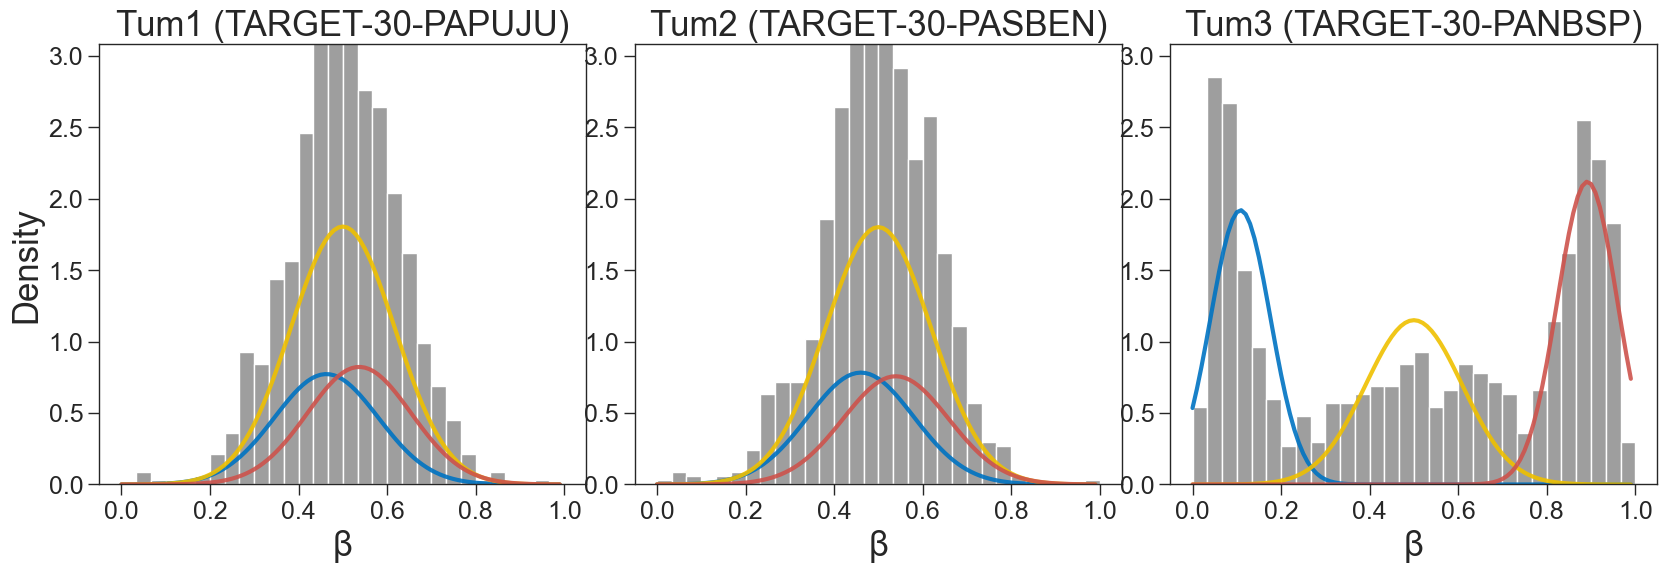

In [138]:
patient_list = {
#     'Tum1':'TARGET-30-PANLET',
    'Tum1':'TARGET-30-PAPUJU',
               'Tum2':'TARGET-30-PASBEN',
               'Tum3':'TARGET-30-PANBSP',
               'Tum3':'TARGET-30-PANBSP'}

# Create plot axes
fig, axes = plt.subplots(1, len(patient_list), figsize=np.array(figsize) * [2.3, 0.8] * sf)
fig.tight_layout(pad=0.2)

# Color of each distribution in order (left -> right)
chosen_tumor_colors = [pc_consts['palette_jco'][i] for i in [0, 1, 3]]

for i, patient in enumerate(patient_list):
    ax = axes[i]
    samp = patient_list[patient]
    
    # Plot distribution
    sns.histplot(ax=ax, x=beta_values_Clock[samp], stat='density',
                 color=pc_consts['palette_jco'][2],
                 bins=30, alpha=pc_consts['opacity'],
                binrange=(0, 1))
    
    # Customize plot
    ax.set_title(f'{patient} ({samp})', fontsize=pc_consts['labelfontsize'] * sf)
    ax.set_xlabel('β', fontsize=pc_consts['labelfontsize'] * sf)
    if i == 0: # Only have y-axis label on left-most plot
        ax.set_ylabel('Density', fontsize=pc_consts['labelfontsize'] * sf)
    else:
        ax.set_ylabel('')
    ax.tick_params(axis='both', labelsize=pc_consts['ticksfontsize'] * sf, width=sf, length=8 * sf)
    
    # Holds the max y-axis limit max
    y_max = float('-Inf')
    
    # Plot each distribution
    # GMM parameters

    # X and Y coords for corve
    x = np.linspace(0, 0.99, 100)
    X = gmm_params['TARGET'].loc[samp]["X_mean"]
    N = gmm_params['TARGET'].loc[samp]["N_mean"]
    y = norm.pdf(x, X, np.sqrt(X * (1 - X) / N)) * gmm_params['TARGET'].loc[samp]["psi_1_mean"]
    
    ax.plot(x, y, lw=3, alpha=0.9,
            color=chosen_tumor_colors[0]
            )
    
    y = norm.pdf(x, 0.5, np.sqrt(0.25 / N)) * gmm_params['TARGET'].loc[samp]["psi_2_mean"]

    y_max = max(y_max, ax.get_ylim()[1])
    
    ax.plot(x, y, lw=3, alpha=0.9,
            color=chosen_tumor_colors[1]
            )
    
    y = norm.pdf(x, 1 - X, np.sqrt(X * (1 - X) / N)) * gmm_params['TARGET'].loc[samp]["psi_3_mean"]

    y_max = max(y_max, ax.get_ylim()[1])
    
    ax.plot(x, y, lw=3, alpha=0.9,
            color=chosen_tumor_colors[2]
            )
    
    y_max = max(y_max, ax.get_ylim()[1])

# Align y-axis limits
for i in range(len(patient_list)):
    ax = axes[i]
    ax.set_ylim(0, y_max * 1.03)

# Save figure
# fig.savefig(os.path.join(figure_outdir, 'example_peak_decomp.pdf'), format='pdf', pad_inches=0.1)

## Estimation

31


Text(0, 0.5, 'Count')

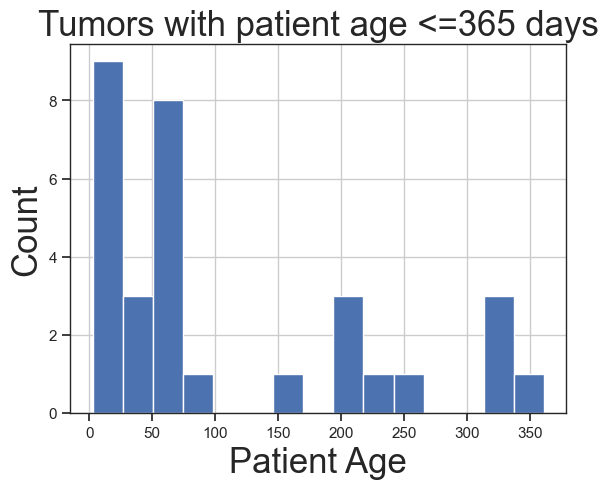

In [139]:
age_day_limit = 80
age_to_make_cutoff = 365

print((clinical[dataset]['age_at_diagnosis'] <= age_to_make_cutoff).sum())

ax = clinical[dataset].loc[clinical[dataset]['age_at_diagnosis'] <= age_to_make_cutoff]['age_at_diagnosis'].hist(bins = 15)
ax.set_xlabel('Patient Age', fontsize=pc_consts['labelfontsize']*sf)
ax.set_title(f'Tumors with patient age <={age_to_make_cutoff} days', fontsize=pc_consts['labelfontsize']*sf)
ax.set_ylabel('Count', fontsize=pc_consts['labelfontsize']*sf)

alpha * mu = 0.00244


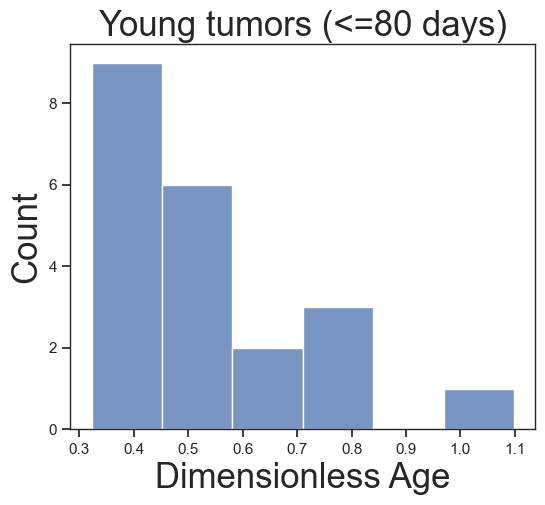

In [140]:
dataset = 'TARGET'

young_tumors = clinical[dataset].index[clinical[dataset]['age_at_diagnosis'] <= age_day_limit]
old_tumors = clinical[dataset].index.difference(young_tumors)


approx_avg_calAge = clinical[dataset].loc[young_tumors]['age_at_diagnosis'].mean() + 6*30

fig, ax = plt.subplots(figsize=np.array([6, 5])*sf)
sns.histplot(ax=ax, data=clinical[dataset].loc[young_tumors], x='gmm_phi')
ax.set_xlabel('Dimensionless Age', fontsize=pc_consts['labelfontsize']*sf)
ax.set_title(f'Young tumors (<={age_day_limit} days)', fontsize=pc_consts['labelfontsize']*sf)
ax.set_ylabel('Count', fontsize=pc_consts['labelfontsize']*sf)

alpha_mu = clinical[dataset].loc[young_tumors]['gmm_phi'].mean() / approx_avg_calAge
print(f'alpha * mu = {alpha_mu:.5f}')

Text(0.5, 1.0, 'TARGET,\nyoung tumors')

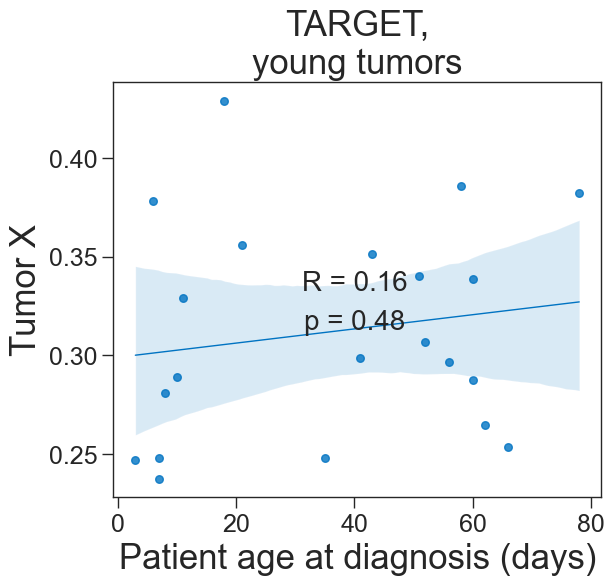

In [141]:
fig, ax = plt.subplots(figsize = figsize * 0.9 * sf)

cor_res = pc_util.getCorrelation(clinical[dataset], 'age_at_diagnosis', 'gmm_X', use_samples=young_tumors)

text_x = 40
text_y = 0.33
pc_util.saveCorrelationPlot(clinical[dataset], var_y='gmm_X',
                           var_x='age_at_diagnosis',
                             outfile=False, ax=ax,
                           text_x=text_x, text_y=text_y,
#                            figsize=figsize * 0.9,
                            xlabel='Patient age at diagnosis (days)', ylabel='Tumor X', use_samples=young_tumors,
                            labelfontsize=pc_consts['labelfontsize'], ticksfontsize=pc_consts['ticksfontsize'], sf=sf, s=30,
                           color=pc_consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

ax.text(text_x, text_y-0.02, f'p = {cor_res.pvalue:.2f}',
                        ha="center", va="bottom",
                        fontfamily='sans-serif', fontsize=0.8 * pc_consts['labelfontsize'] * sf)
ax.set_title(ax.get_title() + ',\nyoung tumors', fontsize=pc_consts['labelfontsize'] * sf)

Text(0.5, 1.0, 'TARGET,\nall tumors')

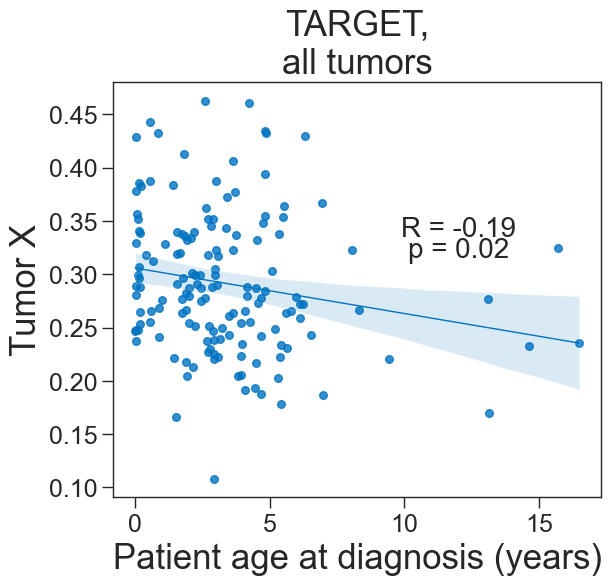

In [142]:
fig, ax = plt.subplots(figsize = figsize * 0.9 * sf)

cor_res = pc_util.getCorrelation(clinical[dataset], 'Age', 'gmm_X')

text_x = 12
text_y = 0.33
pc_util.saveCorrelationPlot(clinical[dataset], var_y='gmm_X',
                           var_x='Age',
                             outfile=False, ax=ax,
                           text_x=text_x, text_y=text_y,
#                            figsize=figsize * 0.9,
                            xlabel='Patient age at diagnosis (years)', ylabel='Tumor X',
                            labelfontsize=pc_consts['labelfontsize'], ticksfontsize=pc_consts['ticksfontsize'], sf=sf, s=30,
                           color=pc_consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

ax.text(text_x, text_y-0.02, f'p = {cor_res.pvalue:.2f}',
                        ha="center", va="bottom",
                        fontfamily='sans-serif', fontsize=0.8 * pc_consts['labelfontsize'] * sf)
ax.set_title(ax.get_title() + ',\nall tumors', fontsize=pc_consts['labelfontsize'] * sf)

Text(0.5, 1.0, 'TARGET,\nyoung tumors')

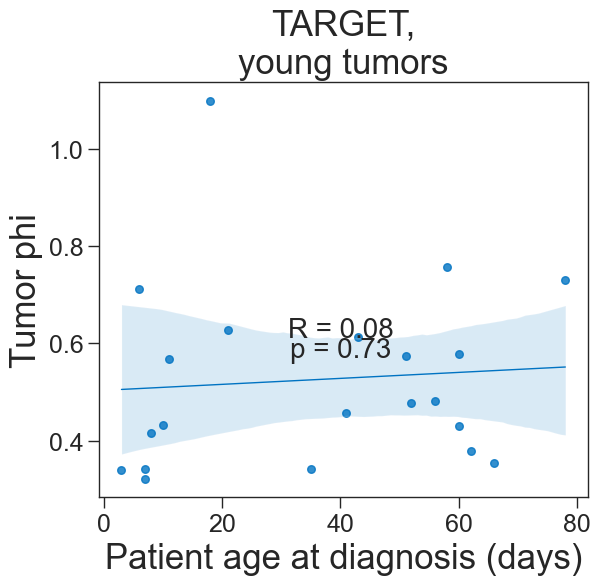

In [143]:
fig, ax = plt.subplots(figsize = figsize * 0.9 * sf)

cor_res = pc_util.getCorrelation(clinical[dataset], 'age_at_diagnosis', 'gmm_phi', use_samples=young_tumors)

text_x = 40
text_y = 0.6
pc_util.saveCorrelationPlot(clinical[dataset], var_y='gmm_phi',
                           var_x='age_at_diagnosis',
                             outfile=False, ax=ax,
                           text_x=text_x, text_y=text_y,
#                            figsize=figsize * 0.9,
                            xlabel='Patient age at diagnosis (days)', ylabel='Tumor phi', use_samples=young_tumors,
                            labelfontsize=pc_consts['labelfontsize'], ticksfontsize=pc_consts['ticksfontsize'], sf=sf, s=30,
                           color=pc_consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

ax.text(text_x, text_y-0.04, f'p = {cor_res.pvalue:.2f}',
                        ha="center", va="bottom",
                        fontfamily='sans-serif', fontsize=0.8 * pc_consts['labelfontsize'] * sf)
ax.set_title(ax.get_title() + ',\nyoung tumors', fontsize=pc_consts['labelfontsize'] * sf)

Text(0.5, 1.0, 'TARGET,\nall tumors')

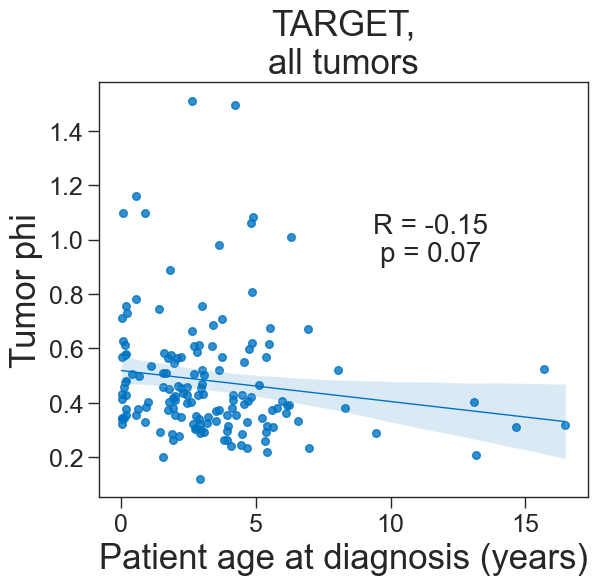

In [144]:
fig, ax = plt.subplots(figsize = figsize * 0.9 * sf)

cor_res = pc_util.getCorrelation(clinical[dataset], 'Age', 'gmm_phi')

text_x = 11.5
text_y = 1
pc_util.saveCorrelationPlot(clinical[dataset], var_y='gmm_phi',
                           var_x='Age',
                             outfile=False, ax=ax,
                           text_x=text_x, text_y=text_y,
#                            figsize=figsize * 0.9,
                            xlabel='Patient age at diagnosis (years)', ylabel='Tumor phi',
                            labelfontsize=pc_consts['labelfontsize'], ticksfontsize=pc_consts['ticksfontsize'], sf=sf, s=30,
                           color=pc_consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

ax.text(text_x, text_y-0.1, f'p = {cor_res.pvalue:.2f}',
                        ha="center", va="bottom",
                        fontfamily='sans-serif', fontsize=0.8 * pc_consts['labelfontsize'] * sf)
ax.set_title(ax.get_title() + ',\nall tumors', fontsize=pc_consts['labelfontsize'] * sf)

In [ ]:
# Generate correlation results
cor_res = pc_util.getCorrelation(clinical[dataset], 'c_beta', 'gmm_phi')

# Plot correlation
fig, ax = plt.subplots(figsize=np.array([30, 24]) * 0.9 * sf)
text_x, text_y = 0.75, 1
pc_util.saveCorrelationPlot(clinical[dataset], var_y='gmm_phi',
                           var_x='c_beta',
                           outfile=False, ax=ax,
                           text_x=text_x, text_y=text_y,
                           xlabel='Patient age at diagnosis (years)', ylabel='Tumor phi',
                           labelfontsize=pc_consts['labelfontsize'], ticksfontsize=pc_consts['ticksfontsize'], sf=sf, s=30,
                           color=pc_consts['palette_jco'][0], line_kws={'linewidth': 1 * sf})

for _, row in clinical[dataset].iterrows():
    if row['submitter_id.1'] in patient_list.values():
        if row['submitter_id.1'] in bad_mean_tumors.index:
            ax.text(row['c_beta'], row['gmm_phi'], row['submitter_id.1'], fontsize=8, ha='right', va='bottom', color='red')
        else:
            ax.text(row['c_beta'], row['gmm_phi'], row['submitter_id.1'], fontsize=8, ha='right', va='bottom', color='blue')
    elif row['submitter_id.1'] in bad_mean_tumors.index:
        ax.text(row['c_beta'], row['gmm_phi'], "X", fontsize=12, ha='right', va='bottom', color='red')
    # else:
    #     ax.text(row['c_beta'], row['gmm_phi'], row['submitter_id.1'], fontsize=8, ha='right', va='bottom', color='blue')

# Add p-value to plot
ax.text(text_x, text_y-0.1, f'p = {cor_res.pvalue:.2f}',
        ha="center", va="bottom",
        fontfamily='sans-serif', fontsize=0.8 * pc_consts['labelfontsize'] * sf)
ax.set_title(ax.get_title() + ',\nall tumors', fontsize=pc_consts['labelfontsize'] * sf)

plt.show()

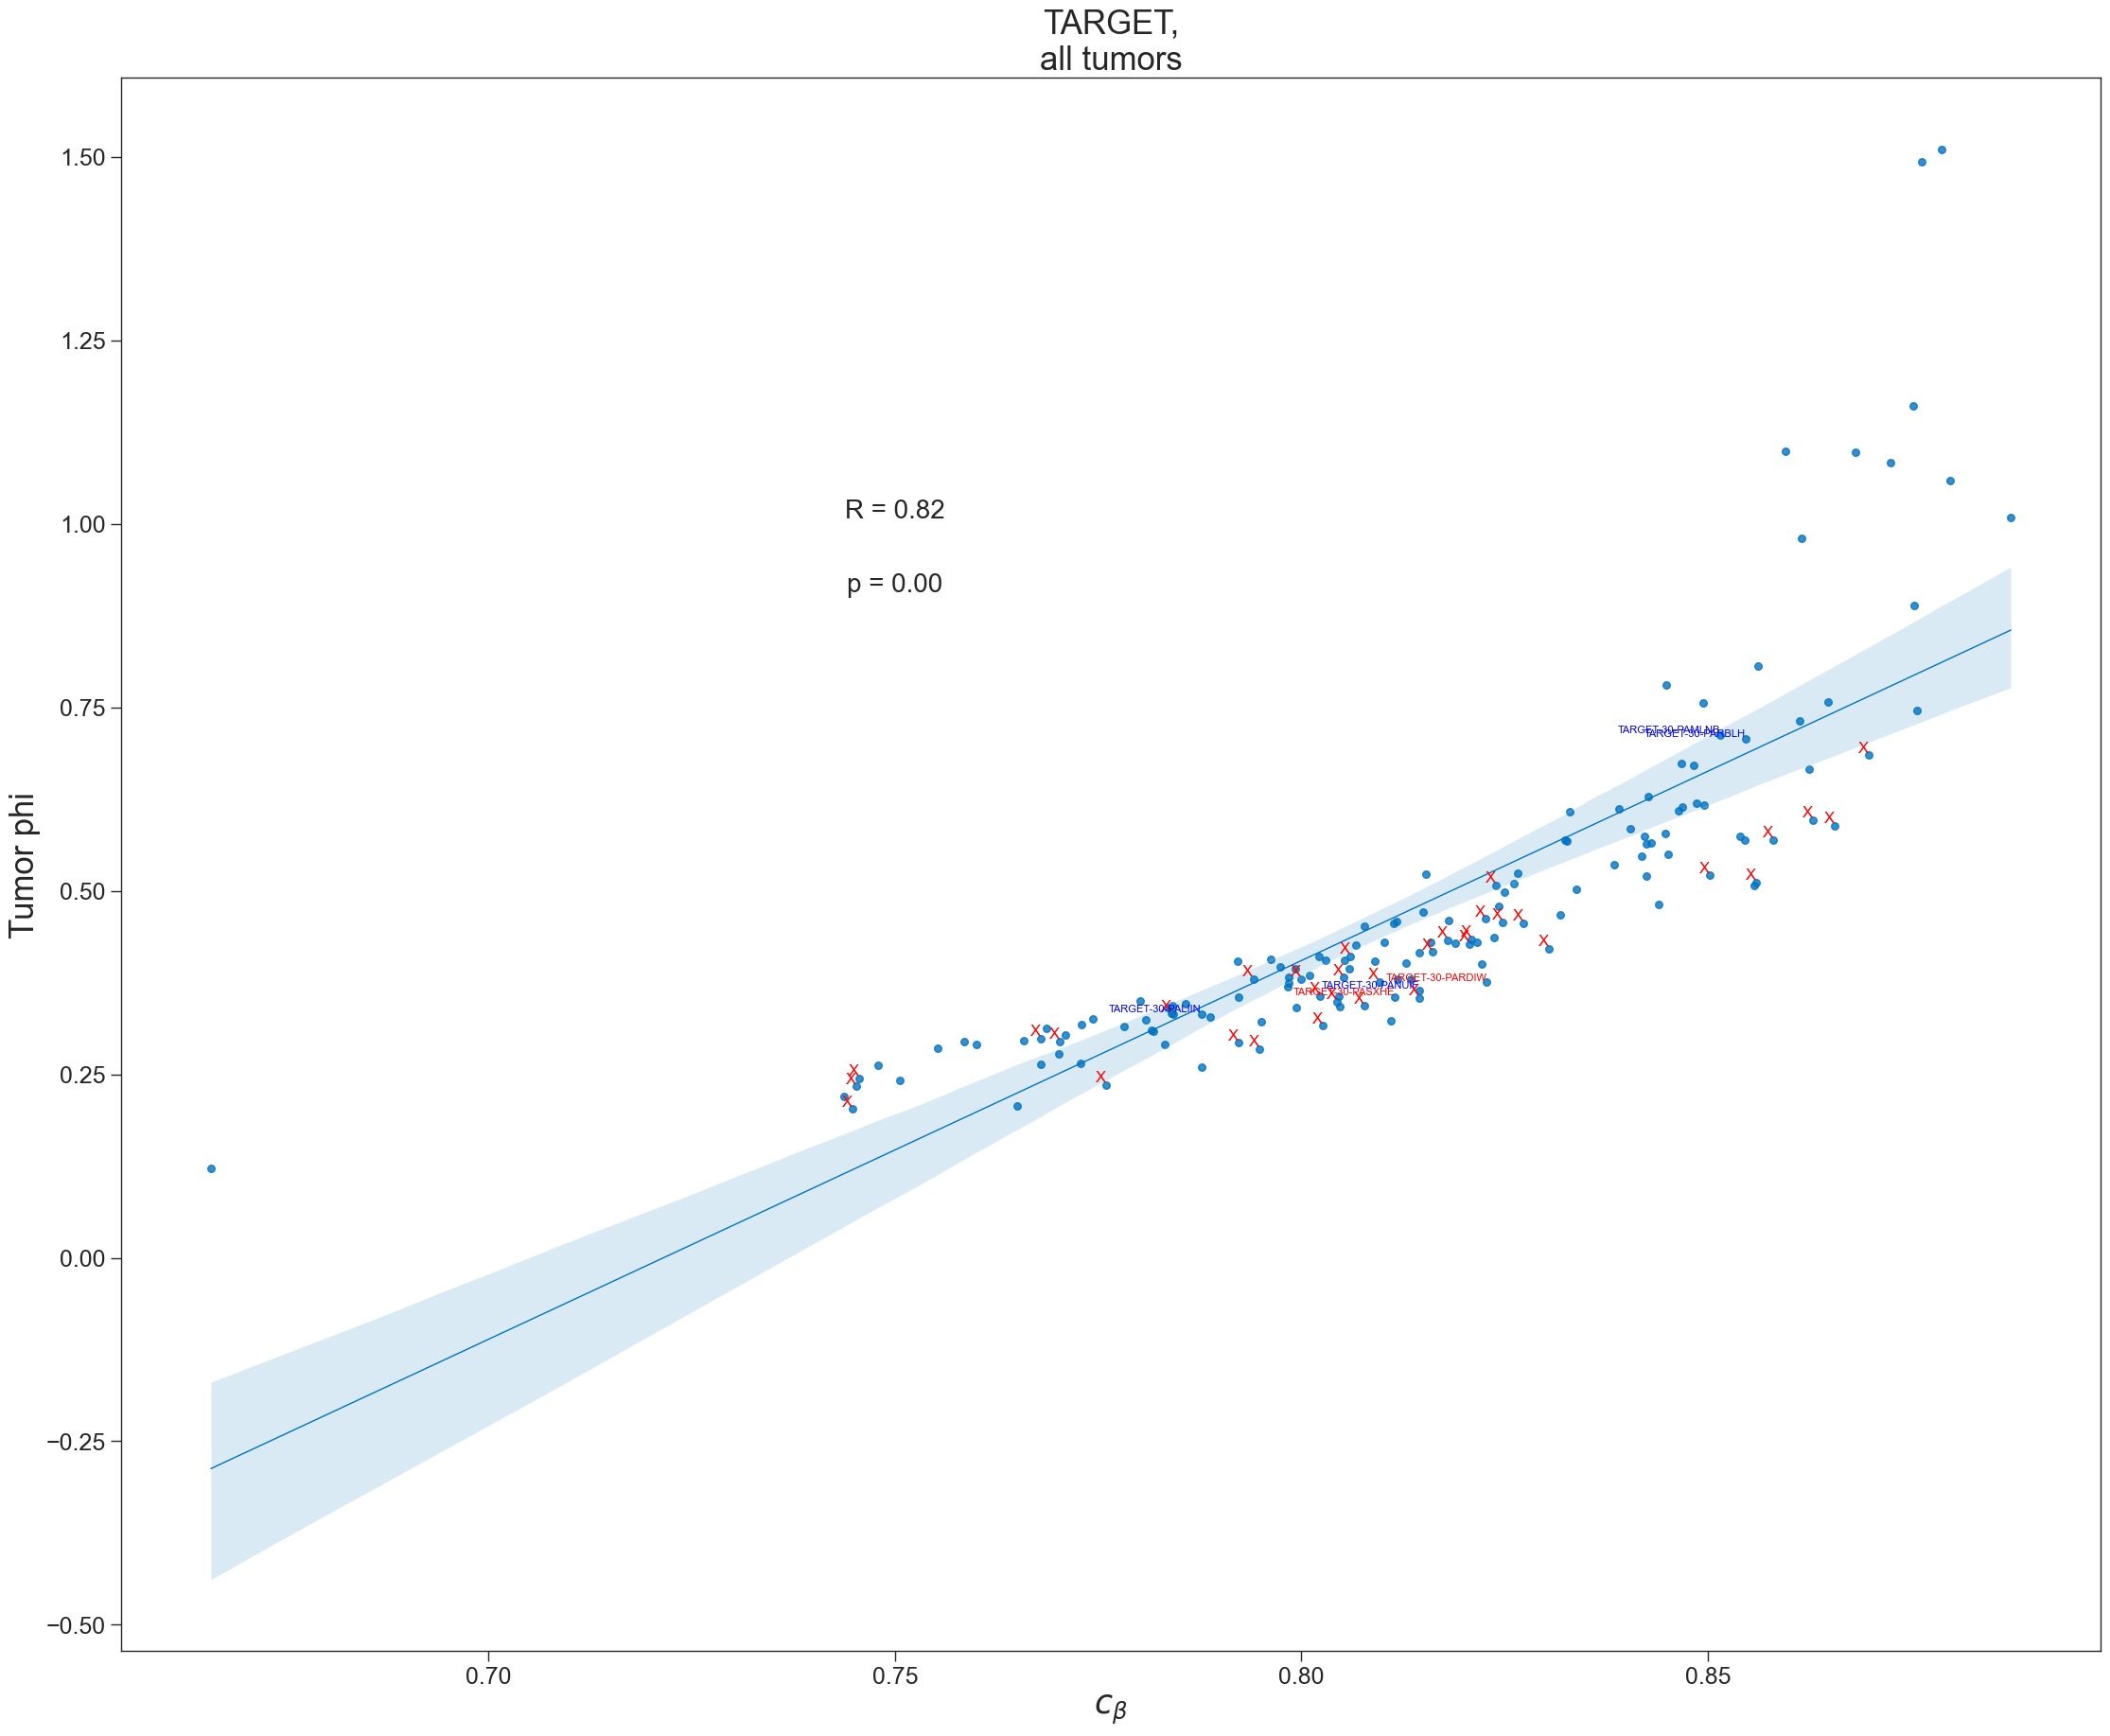

In [168]:
# Generate correlation results
cor_res = pc_util.getCorrelation(clinical[dataset], 'c_beta', 'gmm_phi')

# Plot correlation
fig, ax = plt.subplots(figsize=np.array([30, 24]) * 0.9 * sf)
text_x, text_y = 0.75, 1
pc_util.saveCorrelationPlot(clinical[dataset], var_y='gmm_phi',
                           var_x='c_beta',
                           outfile=False, ax=ax,
                           text_x=text_x, text_y=text_y,
                           xlabel='Patient age at diagnosis (years)', ylabel='Tumor phi',
                           labelfontsize=pc_consts['labelfontsize'], ticksfontsize=pc_consts['ticksfontsize'], sf=sf, s=30,
                           color=pc_consts['palette_jco'][0], line_kws={'linewidth': 1 * sf})

for _, row in clinical[dataset].iterrows():
    if row['submitter_id.1'] in patient_list.values():
        if row['submitter_id.1'] in bad_mean_tumors.index:
            ax.text(row['c_beta'], row['gmm_phi'], row['submitter_id.1'], fontsize=8, ha='right', va='bottom', color='red')
        else:
            ax.text(row['c_beta'], row['gmm_phi'], row['submitter_id.1'], fontsize=8, ha='right', va='bottom', color='blue')
    elif row['submitter_id.1'] in bad_mean_tumors.index:
        ax.text(row['c_beta'], row['gmm_phi'], "X", fontsize=12, ha='right', va='bottom', color='red')
    # else:
    #     ax.text(row['c_beta'], row['gmm_phi'], row['submitter_id.1'], fontsize=8, ha='right', va='bottom', color='blue')

# Add p-value to plot
ax.text(text_x, text_y-0.1, f'p = {cor_res.pvalue:.2f}',
        ha="center", va="bottom",
        fontfamily='sans-serif', fontsize=0.8 * pc_consts['labelfontsize'] * sf)
ax.set_title(ax.get_title() + ',\nall tumors', fontsize=pc_consts['labelfontsize'] * sf)

plt.show()

In [3]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# Copy and prepare the data
df = clinical[dataset].copy()
df["label"] = df["submitter_id.1"]

# Assign colors based on conditions
def color_label(row):
    if row["submitter_id.1"] in bad_mean_tumors.index:
        return "red"
    elif row["submitter_id.1"] in patient_list.values():
        return "blue"
    else:
        return "gray"

df["color"] = df.apply(color_label, axis=1)

# Compute correlation
cor_res = pc_util.getCorrelation(clinical[dataset], 'c_beta', 'gmm_phi')

# Create interactive scatter plot
fig = px.scatter(
    df,
    x='c_beta',
    y='gmm_phi',
    hover_name='submitter_id.1',
    color='color',
    color_discrete_map={"red": "red", "blue": "blue", "gray": "lightgray"},
    labels={"c_beta": "Patient age at diagnosis (years)", "gmm_phi": "Tumor phi"},
    title=f"Correlation of Patient Age and Tumor Phi<br>p = {cor_res.pvalue:.2f}"
)

# Add p-value annotation
fig.add_annotation(
    text=f"p = {cor_res.pvalue:.2f}",
    xref="paper",
    yref="paper",
    x=0.75,
    y=1.1,
    showarrow=False,
    font=dict(size=16)
)

# Function to plot beta distribution for a tumor
def plot_beta_distribution_for_tumor(submitter_id):
    beta_values = beta_matrix[submitter_id].dropna()
    fig2 = go.Figure()
    fig2.add_trace(go.Histogram(
        x=beta_values,
        nbinsx=50,
        marker_color='indigo'
    ))
    fig2.update_layout(
        title=f"Beta Value Distribution for Tumor {submitter_id}",
        xaxis_title="Beta Value",
        yaxis_title="Frequency",
        bargap=0.1
    )
    fig2.show()

# Callback on click to show beta value distribution
def show_beta_distribution(trace, points, selector):
    for i in points.point_inds:
        submitter_id = df.iloc[i]["submitter_id.1"]
        plot_beta_distribution_for_tumor(submitter_id)

# Attach the click callback
fig.data[0].on_click(show_beta_distribution)

# Display the figure
fig.show()


NameError: name 'clinical' is not defined

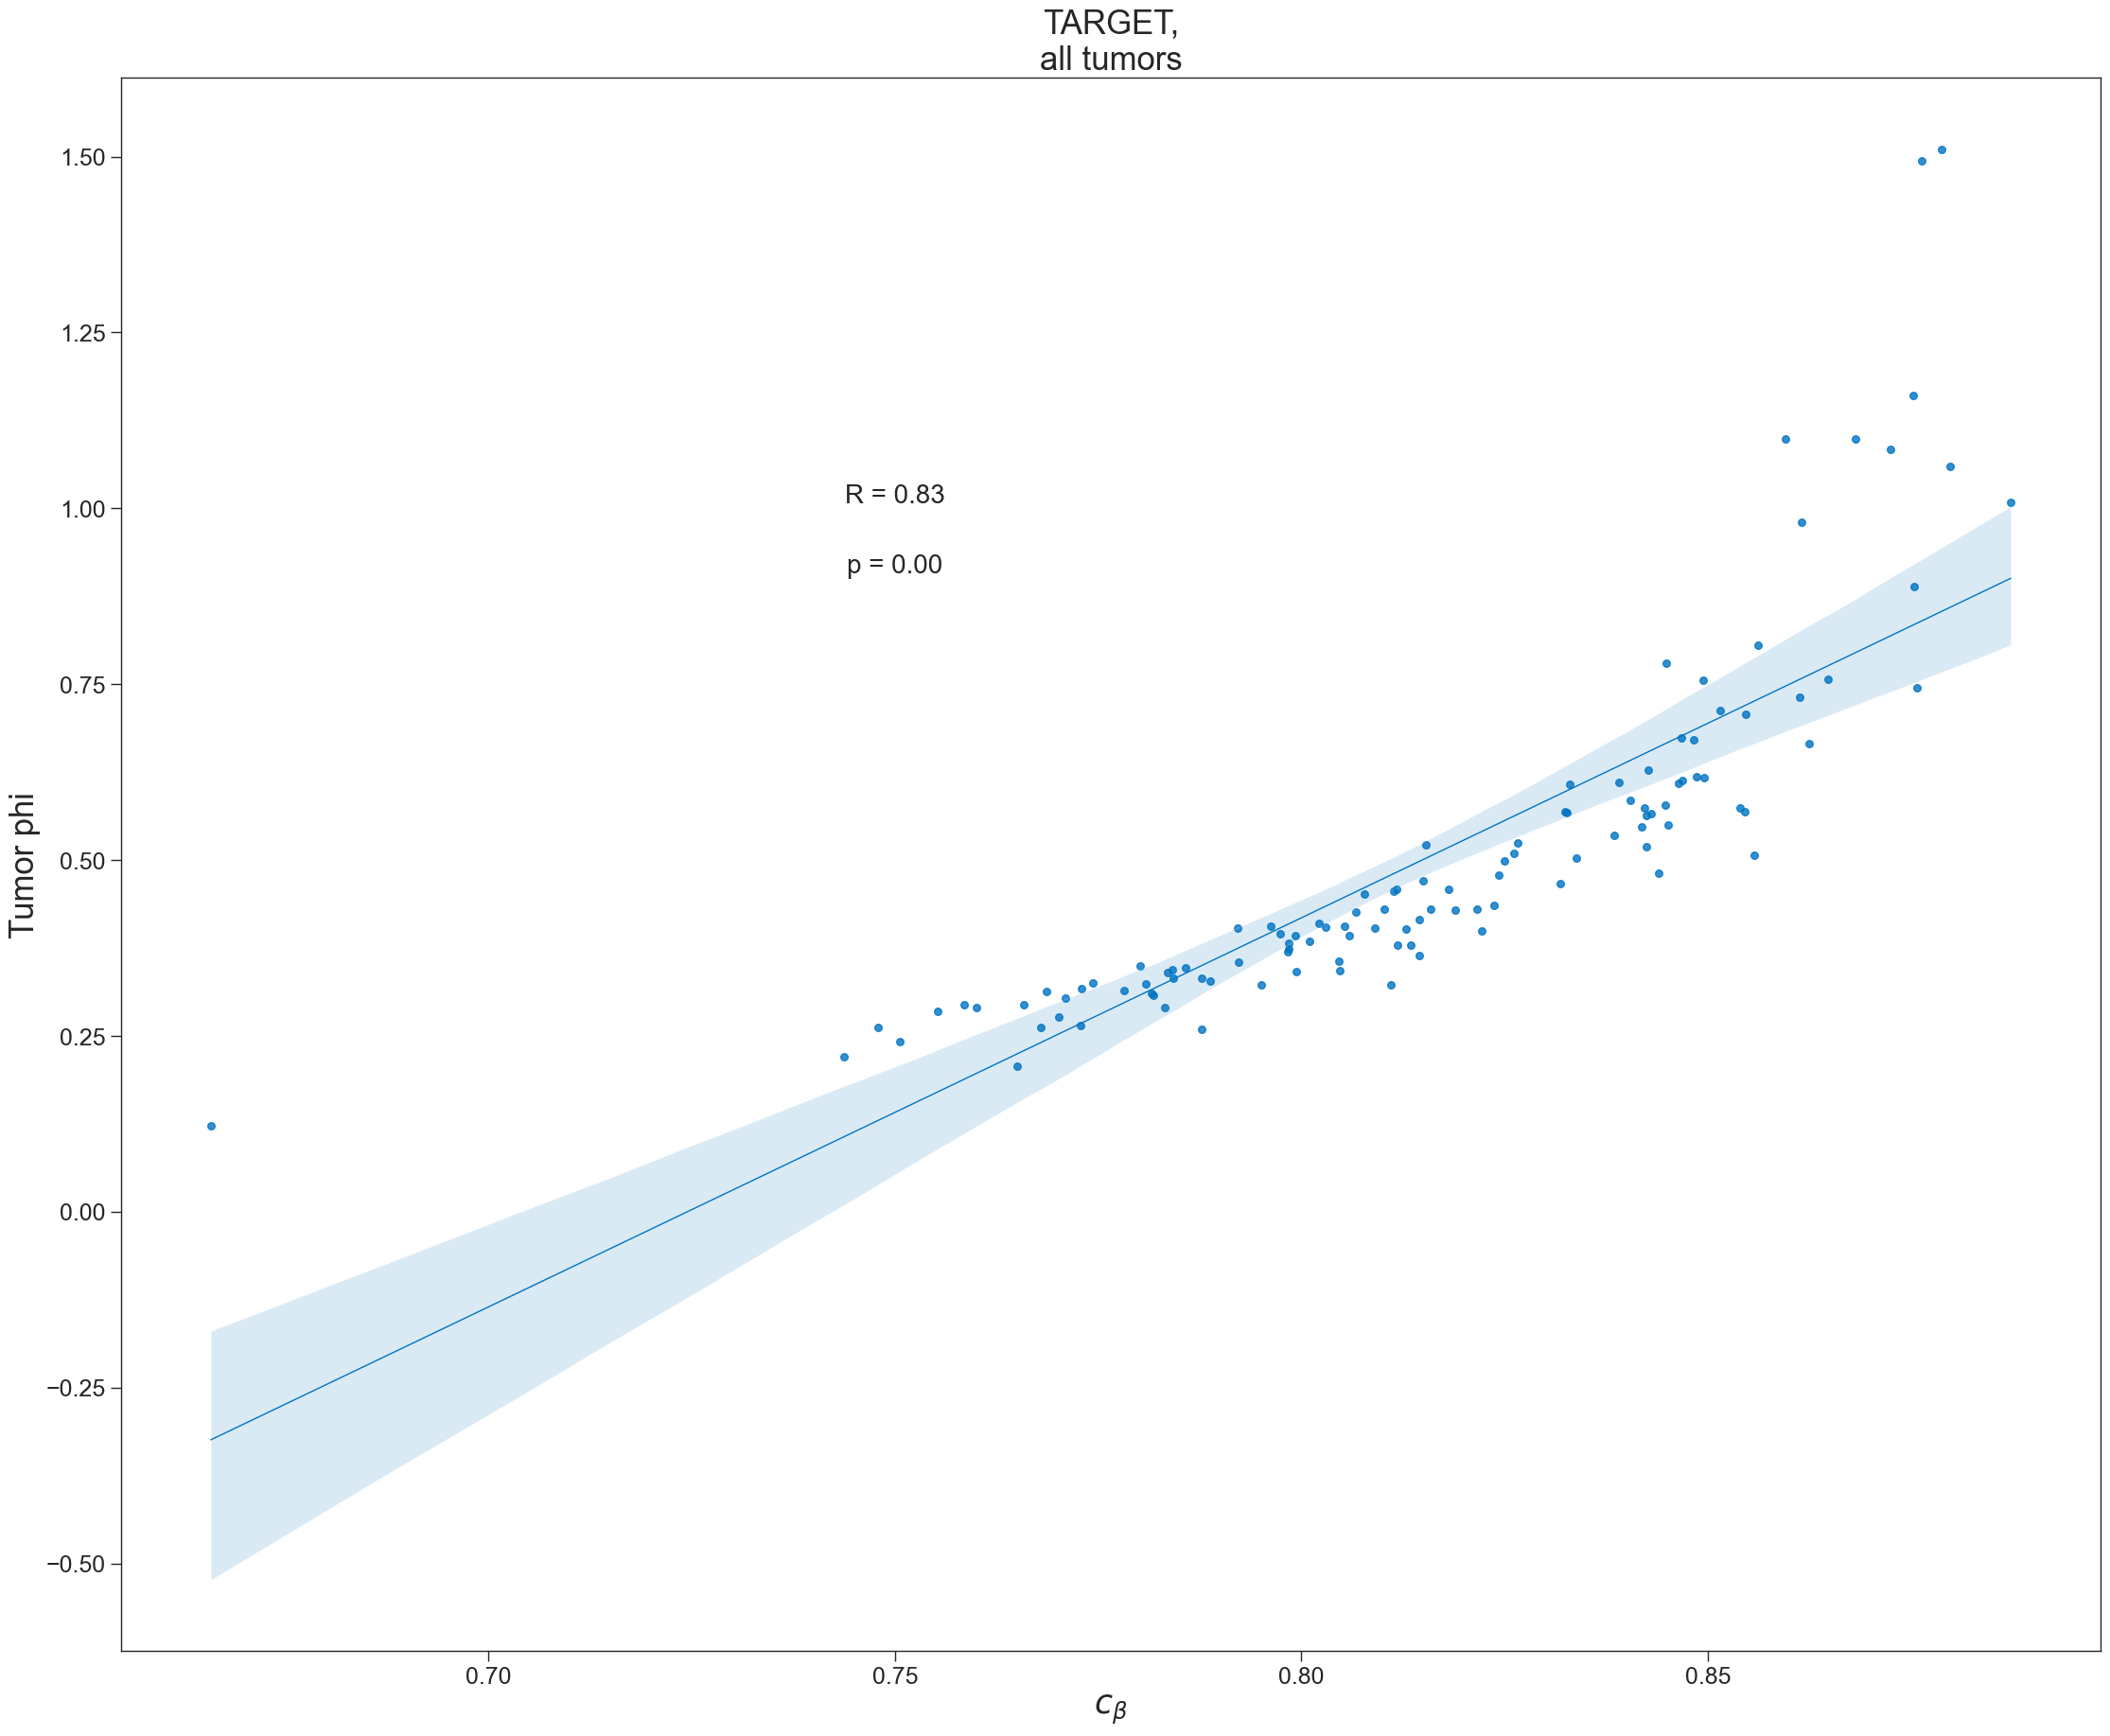

In [160]:
# Generate correlation results
cor_res = pc_util.getCorrelation(clinical[dataset], 'c_beta', 'gmm_phi', use_samples=good_mean_tumors)

# Plot correlation
fig, ax = plt.subplots(figsize=np.array([30, 24]) * 0.9 * sf)
text_x, text_y = 0.75, 1
pc_util.saveCorrelationPlot(clinical[dataset], var_y='gmm_phi',
                           var_x='c_beta',
                           outfile=False, ax=ax,
                           text_x=text_x, text_y=text_y, use_samples=good_mean_tumors,
                           xlabel='Patient age at diagnosis (years)', ylabel='Tumor phi',
                           labelfontsize=pc_consts['labelfontsize'], ticksfontsize=pc_consts['ticksfontsize'], sf=sf, s=30,
                           color=pc_consts['palette_jco'][0], line_kws={'linewidth': 1 * sf})

# Add p-value to plot
ax.text(text_x, text_y-0.1, f'p = {cor_res.pvalue:.2f}',
        ha="center", va="bottom",
        fontfamily='sans-serif', fontsize=0.8 * pc_consts['labelfontsize'] * sf)
ax.set_title(ax.get_title() + ',\nall tumors', fontsize=pc_consts['labelfontsize'] * sf)

plt.show()

In [161]:
column_A = clinical[dataset]['c_beta']
column_B = clinical[dataset]['gmm_phi']

# Compute Spearman rank correlation coefficient
spearman_corr, p_value = spearmanr(column_A, column_B)

print(spearman_corr)
print(p_value)

0.9517567096549319
2.44657003274322e-78


In [162]:
# Select everything NOT in bad_mean_tumors
clinical_good_mean_tumors = clinical[dataset].drop(bad_mean_tumors.index, errors='ignore')

# Extract relevant columns
column_A = clinical_good_mean_tumors['c_beta']
column_B = clinical_good_mean_tumors['gmm_phi']

# Compute Spearman rank correlation coefficient
spearman_corr, p_value = spearmanr(column_A, column_B)

# Print results
print(f"Spearman Rank Correlation: {spearman_corr:.4f}")
print(f"P-value: {p_value:.4e}")

Spearman Rank Correlation: 0.9618
P-value: 2.0287e-65


In [163]:
clinical_bad_mean_tumors = clinical[dataset].loc[bad_mean_tumors.index]

column_A = clinical_bad_mean_tumors['c_beta']
column_B = clinical_bad_mean_tumors['gmm_phi']

# Compute Spearman rank correlation coefficient
spearman_corr, p_value = spearmanr(column_A, column_B)

print(spearman_corr)
print(p_value)

0.9227799227799229
1.2135179771453398e-15


In [164]:
print(bad_mean_tumors.shape)

(36,)


,project,disease_type,primary_site,submitter_id.1,inss_stage,days_to_diagnosis,created_datetime,treatments,last_known_disease_status,tissue_or_organ_of_origin,...,sampleID,c_beta,LUMP,Age,gmm_X,gmm_phi,psi_1_mean,psi_2_mean,psi_3_mean,psi_sub
submitter_id,,,,,,,,,,,,,,,,,,,,,
TARGET-30-PASNPG,TARGET-NBL,Neuroepitheliomatous Neoplasms,Other and ill-defined sites,TARGET-30-PASNPG,Stage 3,0.0,2016-04-25T16:57:09.436943-05:00,"c(\ANBL00B1\"", \""ANBL0531\""), c(\""2024-03-13T1...",NaN,Other ill-defined sites,...,TARGET-30-PASNPG-01A,0.788787,0.796474,0.871233,0.240727,0.328726,0.262339,0.518385,0.219276,0.043063
TARGET-30-PANBSP,TARGET-NBL,Neuroepitheliomatous Neoplasms,Kidney,TARGET-30-PANBSP,Stage 4,0.0,2016-04-25T16:38:00.753908-05:00,"c(\ANBL00B1\"", \""A3973\""), c(\""2024-03-13T17:1...",NaN,"Kidney, NOS",...,TARGET-30-PANBSP-01A,0.665869,0.712484,2.915068,0.108346,0.122132,0.326029,0.314099,0.359873,0.033844


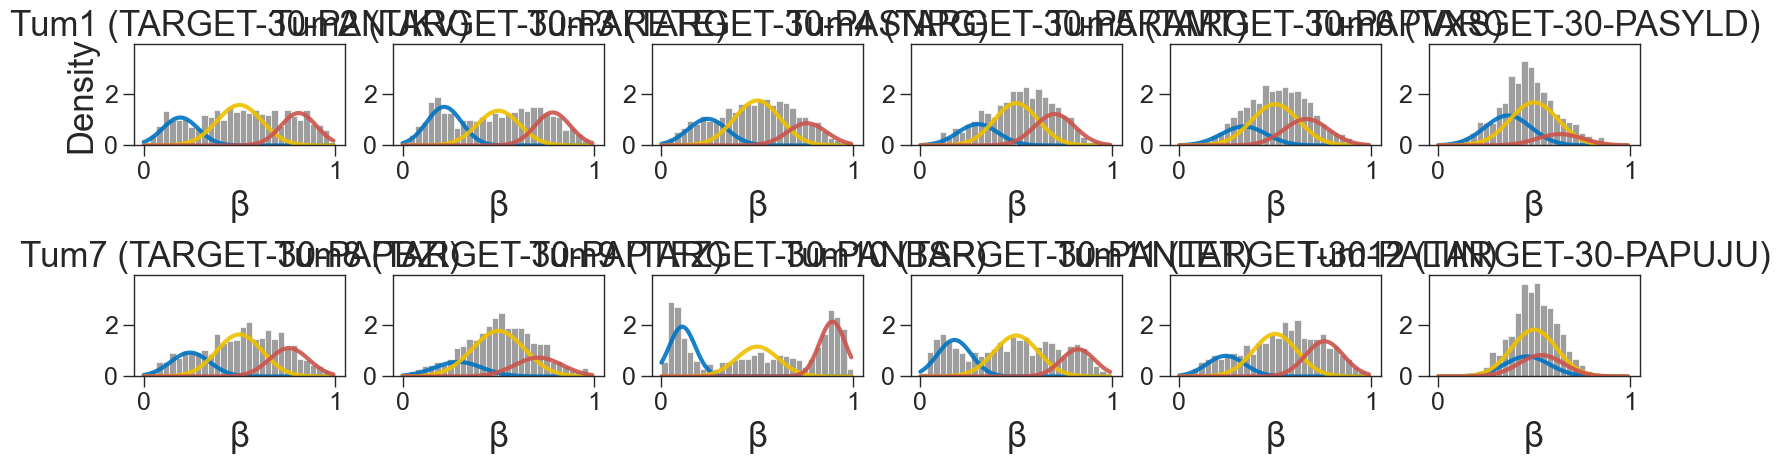

,c_beta,gmm_phi
submitter_id,,
TARGET-30-PANUKV,0.750580,0.241700
TARGET-30-PARETE,0.755270,0.285159
TARGET-30-PASNPG,0.788787,0.328726
TARGET-30-PARAMT,0.818109,0.459304
TARGET-30-PAPVXS,0.832610,0.567855
TARGET-30-PASYLD,0.846778,0.674093
TARGET-30-PAPBZI,0.784252,0.331668
TARGET-30-PAPTFZ,0.811749,0.458677
TARGET-30-PANBSP,0.665869,0.122132


In [172]:
patient_list = {
    'Tum1':'TARGET-30-PANUKV',
    'Tum2':'TARGET-30-PARETE',
    'Tum3':'TARGET-30-PASNPG',
    'Tum4':'TARGET-30-PARAMT',
    'Tum5':'TARGET-30-PAPVXS',
    'Tum6':'TARGET-30-PASYLD',
    'Tum7':'TARGET-30-PAPBZI',
    'Tum8':'TARGET-30-PAPTFZ',
    'Tum9':'TARGET-30-PANBSP',
    'Tum10':'TARGET-30-PANLET',
    'Tum11':'TARGET-30-PALIIN',
    'Tum12':'TARGET-30-PAPUJU',
}

# patient_list = {
#     'Tum1':'TARGET-30-PAPTLD',
#     'Tum3':'TARGET-30-PASNPG',
#     'Tum2':'TARGET-30-PARGUX',
#     'Tum9':'TARGET-30-PANBSP',
# }

# patient_list = {
#     'Tum1':'TARGET-30-PALIIN',
#     'Tum5':'TARGET-30-PAMLNB',
#     'Tum2':'TARGET-30-PASXHE',
#     'Tum3':'TARGET-30-PANUIF',
#     'Tum6':'TARGET-30-PARBLH',
#     'Tum4':'TARGET-30-PARDIW',
# }

# Create plot axes
fig, axes = plt.subplots(2, len(patient_list) // 2, figsize=np.array(figsize) * [2.3, 0.8] * sf)
fig.tight_layout(pad=0.2)

# Color of each distribution in order (left -> right)
chosen_tumor_colors = [pc_consts['palette_jco'][i] for i in [0, 1, 3]]

for i, patient in enumerate(patient_list):
    ax = axes[i // (len(patient_list) // 2)][i % (len(patient_list) // 2)]
    samp = patient_list[patient]
    
    # Plot distribution
    sns.histplot(ax=ax, x=beta_values_Clock[samp], stat='density',
                 color=pc_consts['palette_jco'][2],
                 bins=30, alpha=pc_consts['opacity'],
                binrange=(0, 1))
    
    # Customize plot
    ax.set_title(f'{patient} ({samp})', fontsize=pc_consts['labelfontsize'] * sf)
    ax.set_xlabel('β', fontsize=pc_consts['labelfontsize'] * sf)
    if i == 0: # Only have y-axis label on left-most plot
        ax.set_ylabel('Density', fontsize=pc_consts['labelfontsize'] * sf)
    else:
        ax.set_ylabel('')
    ax.tick_params(axis='both', labelsize=pc_consts['ticksfontsize'] * sf, width=sf, length=8 * sf)
    
    # Holds the max y-axis limit max
    y_max = float('-Inf')
    
    # Plot each distribution
    # GMM parameters

    # X and Y coords for corve
    x = np.linspace(0, 0.99, 100)
    X = gmm_params['TARGET'].loc[samp]["X_mean"]
    N = gmm_params['TARGET'].loc[samp]["N_mean"]
    y = norm.pdf(x, X, np.sqrt(X * (1 - X) / N)) * gmm_params['TARGET'].loc[samp]["psi_1_mean"]
    
    ax.plot(x, y, lw=3, alpha=0.9,
            color=chosen_tumor_colors[0]
            )
    
    y = norm.pdf(x, 0.5, np.sqrt(0.25 / N)) * gmm_params['TARGET'].loc[samp]["psi_2_mean"]

    y_max = max(y_max, ax.get_ylim()[1])
    
    ax.plot(x, y, lw=3, alpha=0.9,
            color=chosen_tumor_colors[1]
            )
    
    y = norm.pdf(x, 1 - X, np.sqrt(X * (1 - X) / N)) * gmm_params['TARGET'].loc[samp]["psi_3_mean"]

    y_max = max(y_max, ax.get_ylim()[1])
    
    ax.plot(x, y, lw=3, alpha=0.9,
            color=chosen_tumor_colors[2]
            )
    
    y_max = max(y_max, ax.get_ylim()[1])

# Align y-axis limits
for i in range(len(patient_list)):
    ax = axes[i // (len(patient_list) // 2)][i % (len(patient_list) // 2)]
    ax.set_ylim(0, y_max * 1.03)

fig.tight_layout()

plt.show()

# Save figure
# fig.savefig(os.path.join(figure_outdir, 'example_peak_decomp.pdf'), format='pdf', pad_inches=0.1)

clinical[dataset].loc[patient_list.values()][['c_beta', 'gmm_phi']]

In [49]:
clinical[dataset].loc[['TARGET-30-PALIIN', 'TARGET-30-PAMLNB'], 'c_beta']

submitter_id
TARGET-30-PALIIN    0.787703
TARGET-30-PAMLNB    0.851484
Name: c_beta, dtype: float64

Text(0.5, 1.0, 'TARGET,\nall tumors')

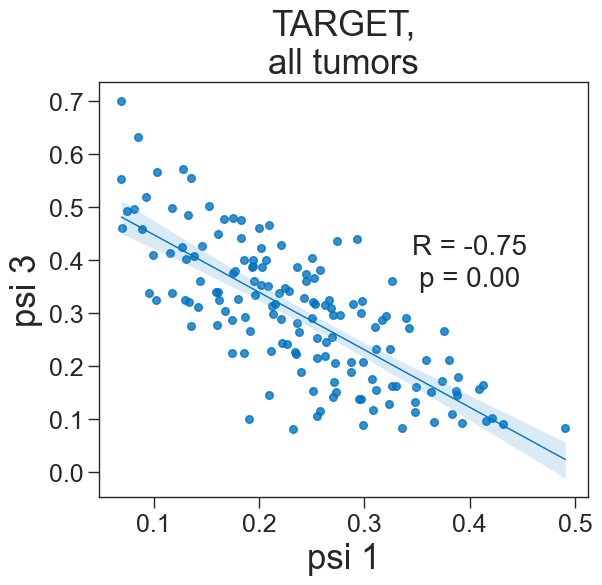

In [50]:
fig, ax = plt.subplots(figsize = figsize * 0.9 * sf)

cor_res = pc_util.getCorrelation(clinical[dataset], 'psi_1_mean', 'psi_3_mean')

text_x = 0.4
text_y = 0.4
pc_util.saveCorrelationPlot(clinical[dataset], var_y='psi_3_mean',
                           var_x='psi_1_mean',
                             outfile=False, ax=ax,
                           text_x=text_x, text_y=text_y,
#                            figsize=figsize * 0.9,
                            xlabel='psi 1', ylabel='psi 3',
                            labelfontsize=pc_consts['labelfontsize'], ticksfontsize=pc_consts['ticksfontsize'], sf=sf, s=30,
                           color=pc_consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

ax.text(text_x, text_y-0.06, f'p = {cor_res.pvalue:.2f}',
                        ha="center", va="bottom",
                        fontfamily='sans-serif', fontsize=0.8 * pc_consts['labelfontsize'] * sf)
ax.set_title(ax.get_title() + ',\nall tumors', fontsize=pc_consts['labelfontsize'] * sf)

Text(0.5, 1.0, 'TARGET,\nall tumors')

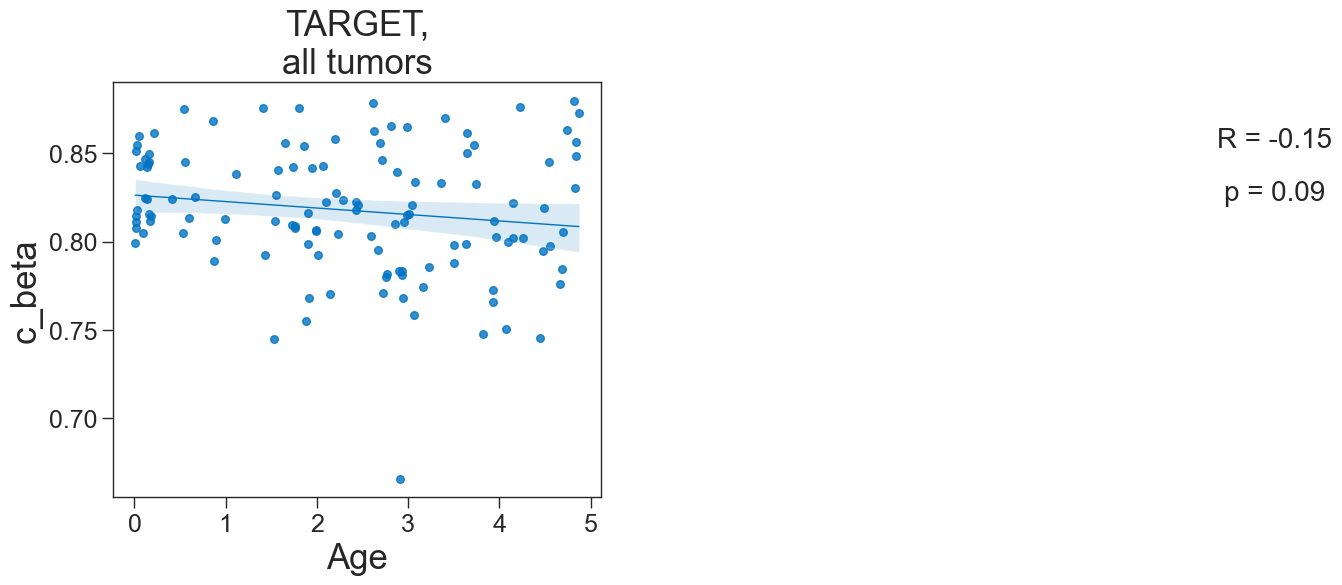

In [51]:
fig, ax = plt.subplots(figsize = figsize * 0.9 * sf)

samples = clinical[dataset].index[clinical[dataset]['Age'] < 5]

cor_res = pc_util.getCorrelation(clinical[dataset], 'Age', 'c_beta', use_samples=samples)

text_x = 12.5
text_y = 0.85
pc_util.saveCorrelationPlot(clinical[dataset], var_y='c_beta',
                           var_x='Age',
                             outfile=False, ax=ax,
                           text_x=text_x, text_y=text_y,
#                            figsize=figsize * 0.9,
                            xlabel='Age', ylabel='c_beta', use_samples=samples,
                            labelfontsize=pc_consts['labelfontsize'], ticksfontsize=pc_consts['ticksfontsize'], sf=sf, s=30,
                           color=pc_consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

ax.text(text_x, text_y-0.03, f'p = {cor_res.pvalue:.2f}',
                        ha="center", va="bottom",
                        fontfamily='sans-serif', fontsize=0.8 * pc_consts['labelfontsize'] * sf)
ax.set_title(ax.get_title() + ',\nall tumors', fontsize=pc_consts['labelfontsize'] * sf)

project                                                                     TARGET-NBL
disease_type                                            Neuroepitheliomatous Neoplasms
primary_site                                                             Adrenal gland
submitter_id.1                                                        TARGET-30-PARGUX
inss_stage                                                                     Stage 4
days_to_diagnosis                                                                  0.0
created_datetime                                      2016-04-25T16:43:05.111061-05:00
treatments                           ANBL00B1, 2024-03-13T17:13:56.180548-05:00, 7f...
last_known_disease_status                                                          NaN
tissue_or_organ_of_origin                                           Adrenal gland, NOS
days_to_last_follow_up                                                             NaN
age_at_diagnosis                           

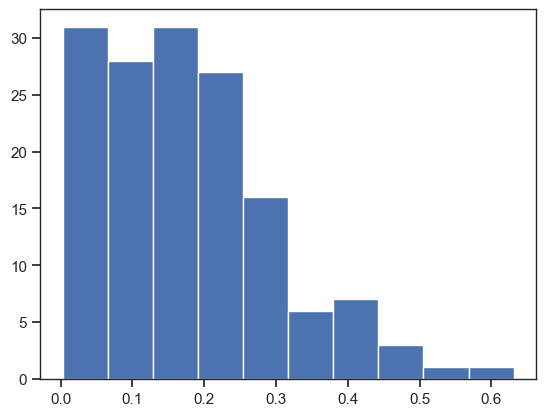

In [52]:
clinical[dataset]['psi_sub'] = abs(clinical[dataset]['psi_1_mean'] - clinical[dataset]['psi_3_mean'])

plt.hist(clinical[dataset]['psi_sub'])

display(clinical[dataset].loc['TARGET-30-PARGUX'])

Index(['TARGET-30-PASUCB', 'TARGET-30-PASNPG', 'TARGET-30-PARNEE',
       'TARGET-30-PALXTB', 'TARGET-30-PAMMXF', 'TARGET-30-PAPTCR',
       'TARGET-30-PANBSP', 'TARGET-30-PANZPV', 'TARGET-30-PAPBJE',
       'TARGET-30-PAPRXW',
       ...
       'TARGET-30-PASYLD', 'TARGET-30-PASWYR', 'TARGET-30-PALCBW',
       'TARGET-30-PARCET', 'TARGET-30-PAPEAV', 'TARGET-30-PALVVH',
       'TARGET-30-PATYIL', 'TARGET-30-PAPBGH', 'TARGET-30-PAREGK',
       'TARGET-30-PAMZSH'],
      dtype='object', name='submitter_id', length=129)


Text(0.5, 1.0, 'TARGET,\nall tumors')

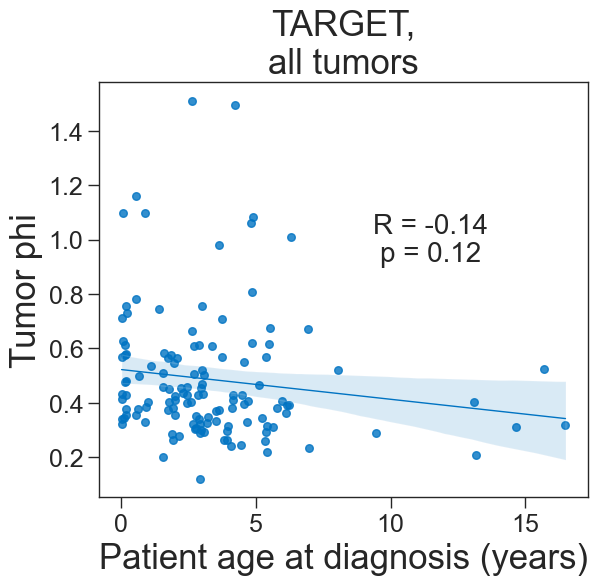

In [53]:
even_weight_tumors = clinical[dataset].index[clinical[dataset]['psi_sub'] < 0.3]

print(even_weight_tumors)

fig, ax = plt.subplots(figsize = figsize * 0.9 * sf)

cor_res = pc_util.getCorrelation(clinical[dataset], 'Age', 'gmm_phi', use_samples=even_weight_tumors)

text_x = 11.5
text_y = 1
pc_util.saveCorrelationPlot(clinical[dataset], var_y='gmm_phi',
                           var_x='Age',
                             outfile=False, ax=ax,
                           text_x=text_x, text_y=text_y,
#                            figsize=figsize * 0.9,
                            xlabel='Patient age at diagnosis (years)', ylabel='Tumor phi', use_samples=even_weight_tumors,
                            labelfontsize=pc_consts['labelfontsize'], ticksfontsize=pc_consts['ticksfontsize'], sf=sf, s=30,
                           color=pc_consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

ax.text(text_x, text_y-0.1, f'p = {cor_res.pvalue:.2f}',
                        ha="center", va="bottom",
                        fontfamily='sans-serif', fontsize=0.8 * pc_consts['labelfontsize'] * sf)
ax.set_title(ax.get_title() + ',\nall tumors', fontsize=pc_consts['labelfontsize'] * sf)

In [54]:
dataset = 'TARGET'

# Calculate calendar ages
clinical[dataset]['calendar_age'] = clinical[dataset]['gmm_phi'] / alpha_mu
clinical[dataset].name = 'TARGET'

## Plots

### Young tumors

Text(0.5, 1.0, 'TARGET,\nyoung tumors (<=80 days)')

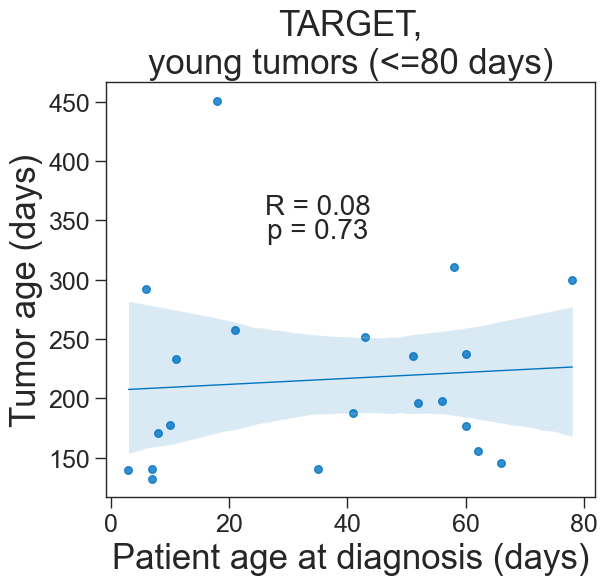

In [55]:
fig, ax = plt.subplots(figsize = figsize * 0.9 * sf)

cor_res = pc_util.getCorrelation(clinical[dataset], 'age_at_diagnosis', 'calendar_age', use_samples=young_tumors)

text_x = 35
text_y = 350
pc_util.saveCorrelationPlot(clinical[dataset], var_y='calendar_age',
                           var_x='age_at_diagnosis', use_samples=young_tumors,
                             outfile=False, ax=ax,
                           text_x=text_x, text_y=text_y,
#                            figsize=figsize * 0.9,
                            xlabel='Patient age at diagnosis (days)', ylabel='Tumor age (days)',
                            labelfontsize=pc_consts['labelfontsize'], ticksfontsize=pc_consts['ticksfontsize'], sf=sf, s=30,
                           color=pc_consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

ax.text(text_x, text_y-20, f'p = {cor_res.pvalue:.2f}',
                        ha="center", va="bottom",
                        fontfamily='sans-serif', fontsize=0.8 * pc_consts['labelfontsize'] * sf)
ax.set_title(ax.get_title() + f',\nyoung tumors (<={age_day_limit} days)', fontsize=pc_consts['labelfontsize'] * sf)

### Old tumors

Text(0.5, 1.0, 'TARGET,\nold tumors (>=80 days)')

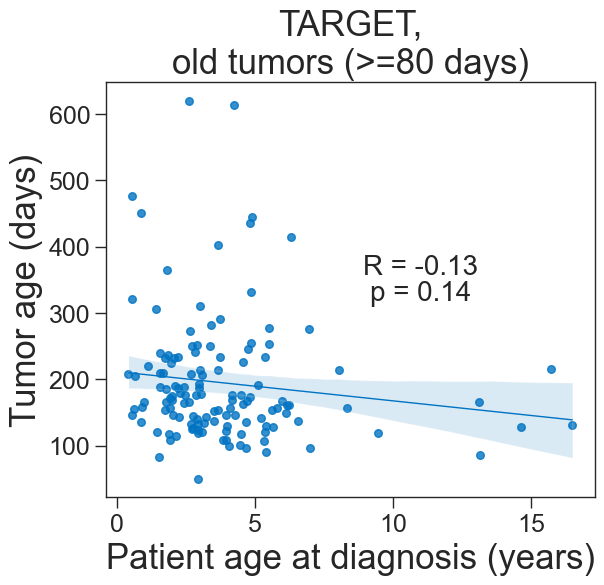

In [56]:
fig, ax = plt.subplots(figsize = figsize * 0.9 * sf)

old_tumors = clinical[dataset].index[~np.isin(clinical[dataset].index, young_tumors)]

cor_res = pc_util.getCorrelation(clinical[dataset], 'Age', 'calendar_age', use_samples=old_tumors)

text_x = 11
text_y = 350
pc_util.saveCorrelationPlot(clinical[dataset], var_y='calendar_age',
                           var_x='Age', use_samples=old_tumors,
                             outfile=False, ax=ax,
                           text_x=text_x, text_y=text_y,
#                            figsize=figsize * 0.9,
                            xlabel='Patient age at diagnosis (years)', ylabel='Tumor age (days)',
                            labelfontsize=pc_consts['labelfontsize'], ticksfontsize=pc_consts['ticksfontsize'], sf=sf, s=30,
                           color=pc_consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

ax.text(text_x, text_y-40, f'p = {cor_res.pvalue:.2f}',
                        ha="center", va="bottom",
                        fontfamily='sans-serif', fontsize=0.8 * pc_consts['labelfontsize'] * sf)
ax.set_title(ax.get_title() + f',\nold tumors (>={age_day_limit} days)', fontsize=pc_consts['labelfontsize'] * sf)

### All tumors

Text(0.5, 1.0, 'TARGET,\nall tumors')

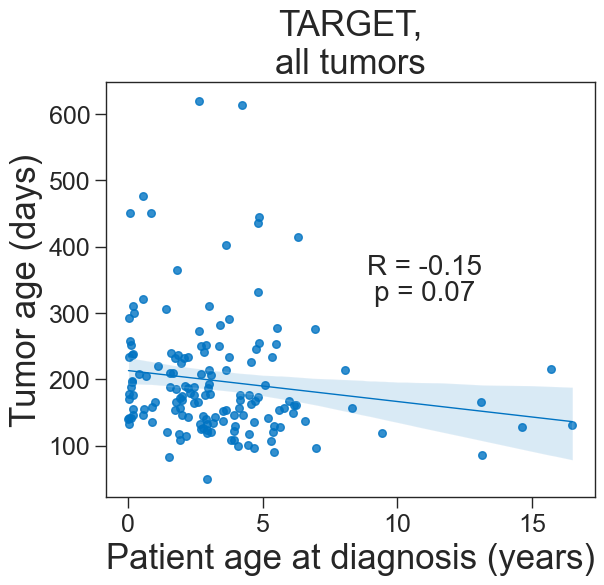

In [57]:
fig, ax = plt.subplots(figsize = figsize * 0.9 * sf)

cor_res = pc_util.getCorrelation(clinical[dataset], 'Age', 'calendar_age')

text_x = 11
text_y = 350
pc_util.saveCorrelationPlot(clinical[dataset], var_y='calendar_age',
                           var_x='Age',
                             outfile=False, ax=ax,
                           text_x=text_x, text_y=text_y,
#                            figsize=figsize * 0.9,
                            xlabel='Patient age at diagnosis (years)', ylabel='Tumor age (days)',
                            labelfontsize=pc_consts['labelfontsize'], ticksfontsize=pc_consts['ticksfontsize'], sf=sf, s=30,
                           color=pc_consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

ax.text(text_x, text_y-40, f'p = {cor_res.pvalue:.2f}',
                        ha="center", va="bottom",
                        fontfamily='sans-serif', fontsize=0.8 * pc_consts['labelfontsize'] * sf)
ax.set_title(ax.get_title() + ',\nall tumors', fontsize=pc_consts['labelfontsize'] * sf)

In [58]:
clinical[dataset].loc['TARGET-30-PAIXFZ']

project                                                                     TARGET-NBL
disease_type                                            Neuroepitheliomatous Neoplasms
primary_site                                                                   Unknown
submitter_id.1                                                        TARGET-30-PAIXFZ
inss_stage                                                                    Stage 4S
days_to_diagnosis                                                                  0.0
created_datetime                                      2016-04-25T16:33:30.343664-05:00
treatments                           9047, 2024-03-13T17:13:56.180548-05:00, 1158e5...
last_known_disease_status                                                          NaN
tissue_or_organ_of_origin                                                      Unknown
days_to_last_follow_up                                                             NaN
age_at_diagnosis                           

In [30]:
pc_util.getCorrelation(clinical[dataset], 'calendar_age', 'Age')

LinregressResult(slope=np.float64(-4.666969470837883), intercept=np.float64(212.97997027485664), rvalue=np.float64(-0.14542854506145741), pvalue=np.float64(0.07479976742899433), stderr=np.float64(2.6010599285636555), intercept_stderr=np.float64(11.450842344763204))

In [31]:
pc_util.getCorrelation(clinical[dataset], 'c_beta', 'Age')

LinregressResult(slope=np.float64(-0.002955442690360872), intercept=np.float64(0.824545273665241), rvalue=np.float64(-0.23869781485448663), pvalue=np.float64(0.0031615147463545123), stderr=np.float64(0.0009850135134912463), intercept_stderr=np.float64(0.004336399298834344))

## Examine calendar age vs $c_\beta$

In [ ]:
pc_util.getCorrelation(clinical[dataset], 'calendar_age', 'c_beta')

In [ ]:
sns.scatterplot(data=clinical[dataset], x='c_beta', y='calendar_age')

In [ ]:
# Outliers in above plot
outlier_tumors = clinical[dataset].loc[clinical[dataset]['calendar_age'] < 80].index.values

# Correlation without outliers
pc_util.getCorrelation(clinical[dataset], 'calendar_age', 'c_beta', use_samples=clinical[dataset].index[~np.isin(clinical[dataset].index, outlier_tumors)])

### Examine outlier tumors

In [ ]:
patient_list = {
    'Tum1':outlier_tumors[0],
    'Tum2':outlier_tumors[1]
}

# Create plot axes
fig, axes = plt.subplots(1, len(patient_list), figsize=np.array(figsize) * [2.3, 0.8] * sf)
fig.tight_layout(pad=3)
fig.suptitle('Outlier tumors', y=1.3, fontsize=pc_consts['labelfontsize'] * 1.2 * sf, fontweight='bold')

# Color of each distribution in order (left -> right)
chosen_tumor_colors = [pc_consts['palette_jco'][i] for i in [0, 1, 3]]

for i, patient in enumerate(patient_list):
    ax = axes[i]
    samp = patient_list[patient]
    
    # Plot distribution
    sns.histplot(ax=ax, x=beta_values_Clock[samp], stat='density',
                 color=pc_consts['palette_jco'][2],
                 bins=30, alpha=pc_consts['opacity'],
                binrange=(0, 1))
    
    # Customize plot
    ax.set_title(f'{patient} ({samp})', fontsize=pc_consts['labelfontsize'] * sf)
    ax.set_xlabel('β', fontsize=pc_consts['labelfontsize'] * sf)
    if i == 0: # Only have y-axis label on left-most plot
        ax.set_ylabel('Density', fontsize=pc_consts['labelfontsize'] * sf)
    else:
        ax.set_ylabel('')
    ax.tick_params(axis='both', labelsize=pc_consts['ticksfontsize'] * sf, width=sf, length=8 * sf)

    # Weight of each of three distributions
    weight_list = phi['TARGET'].loc[samp]
    
    # Holds the max y-axis limit max
    y_max = float('-Inf')
    
    # Plot each distribution
    for j, model in enumerate(alpha['TARGET'].columns):
        
        # Beta dist. parameters
        a = alpha['TARGET'].loc[samp, model]
        d = delta['TARGET'].loc[samp, model]

        # X and Y coords for corve
        x = np.linspace(0, 0.99, 100)
        y = beta.pdf(x, a, d) * weight_list[j]
        
        # Plot curve
        ax.plot(x, y, lw=3, alpha=0.9,
                color=chosen_tumor_colors[j]
               )
        
        # Update max
        y_max = max(y_max, ax.get_ylim()[1])

# Align y-axis limits
for i in range(len(patient_list)):
    ax = axes[i]
    ax.set_ylim(0, y_max * 1.03)

# Save figure
# fig.savefig(os.path.join(figure_outdir, 'example_peak_decomp.pdf'), format='pdf', pad_inches=0.1)